In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

2023-06-15 22:42:57.033736: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=20

In [8]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [9]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [10]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


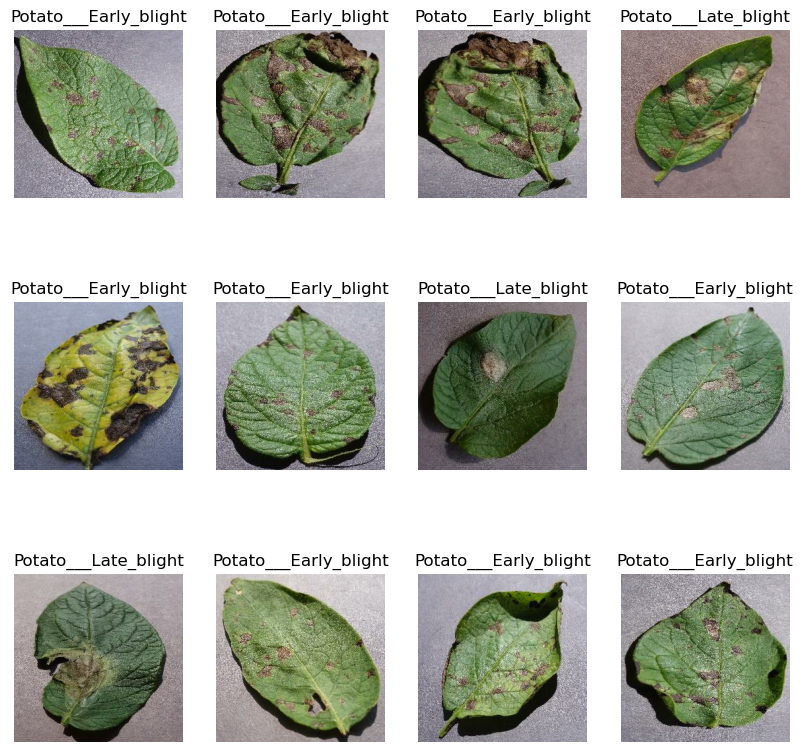

In [11]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [12]:
len(dataset)

68

In [9]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [10]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [11]:
len(train_ds)

54

In [12]:
len(val_ds)

6

In [13]:
len(test_ds)

8

In [14]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [15]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [16]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [19]:
from tensorflow.keras import models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, concatenate

In [26]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model_sn = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(64, kernel_size=(3, 3), strides=(2, 2), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
    layers.Conv2D(64, kernel_size=(1, 1), activation='relu'),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.Conv2D(n_classes, kernel_size=(1, 1), activation='softmax'),
    layers.GlobalAveragePooling2D(),
])

model_sn.build(input_shape=input_shape)


In [27]:
model_sn.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (256, 256, 3)             0         
                                                                 
 conv2d_12 (Conv2D)          (32, 127, 127, 64)        1792      
                                                                 
 max_pooling2d_3 (MaxPooling  (32, 63, 63, 64)         0         
 2D)                                                             
                                                                 
 conv2d_13 (Conv2D)          (32, 63, 63, 64)          4160      
                                                                 
 conv2d_14 (Conv2D)          (32, 61, 61, 64)          36928     
                                                                 
 conv2d_15 (Conv2D)          (32, 61, 61, 3)           195       
                                                      

In [28]:
model_sn.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [25]:
history = model_sn.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=25,
)

Epoch 1/25
54/54 [==============================] - 27s 507ms/step - loss: 0.8203 - accuracy: 0.6499 - val_loss: 0.7657 - val_accuracy: 0.7448
Epoch 2/25
54/54 [==============================] - 30s 558ms/step - loss: 0.7110 - accuracy: 0.7529 - val_loss: 0.6914 - val_accuracy: 0.7292
Epoch 3/25
54/54 [==============================] - 32s 593ms/step - loss: 0.6240 - accuracy: 0.7957 - val_loss: 0.6583 - val_accuracy: 0.6927
Epoch 4/25
54/54 [==============================] - 37s 685ms/step - loss: 0.5464 - accuracy: 0.8171 - val_loss: 0.5728 - val_accuracy: 0.7292
Epoch 5/25
54/54 [==============================] - 43s 797ms/step - loss: 0.4864 - accuracy: 0.8414 - val_loss: 0.5114 - val_accuracy: 0.7865
Epoch 6/25
54/54 [==============================] - 56s 1s/step - loss: 0.4325 - accuracy: 0.8542 - val_loss: 0.5016 - val_accuracy: 0.7708
Epoch 7/25
54/54 [==============================] - 59s 1s/step - loss: 0.4042 - accuracy: 0.8594 - val_loss: 0.4669 - val_accuracy: 0.8177
Epoch

In [29]:
history_sn = history

In [31]:
scores = model_sn.evaluate(test_ds)

8/8 [==============================] - 1s 115ms/step - loss: 1.0860 - accuracy: 0.5000


In [32]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [33]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (256, 256, 3)             0         
                                                                 
 conv2d_16 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPooling  (32, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 conv2d_17 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_18 (Conv2D)          (32, 60, 60, 64)         

In [34]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [37]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=20,
)

Epoch 1/20
54/54 [==============================] - 269s 5s/step - loss: 0.8903 - accuracy: 0.5260 - val_loss: 0.8829 - val_accuracy: 0.6458
Epoch 2/20
54/54 [==============================] - 211s 4s/step - loss: 0.7259 - accuracy: 0.6661 - val_loss: 0.5493 - val_accuracy: 0.7135
Epoch 3/20
54/54 [==============================] - 210s 4s/step - loss: 0.4526 - accuracy: 0.8073 - val_loss: 0.3971 - val_accuracy: 0.8177
Epoch 4/20
54/54 [==============================] - 199s 4s/step - loss: 0.3091 - accuracy: 0.8727 - val_loss: 0.2745 - val_accuracy: 0.8802
Epoch 5/20
54/54 [==============================] - 176s 3s/step - loss: 0.2102 - accuracy: 0.9178 - val_loss: 0.1913 - val_accuracy: 0.9115
Epoch 6/20
54/54 [==============================] - 138s 3s/step - loss: 0.2050 - accuracy: 0.9190 - val_loss: 0.1575 - val_accuracy: 0.9427
Epoch 7/20
54/54 [==============================] - 142s 3s/step - loss: 0.1608 - accuracy: 0.9352 - val_loss: 0.1632 - val_accuracy: 0.9375
Epoch 8/20
54

In [38]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 3s 425ms/step - loss: 0.0504 - accuracy: 0.9961


In [39]:
scores

[0.05036446824669838, 0.99609375]

In [40]:
history

In [41]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [42]:
type(history.history['loss'])

list

In [43]:
len(history.history['loss'])

20

In [46]:
history.history['loss'][:5]

[0.8902907967567444,
 0.7258991003036499,
 0.4526278078556061,
 0.3090701997280121,
 0.21022221446037292]

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

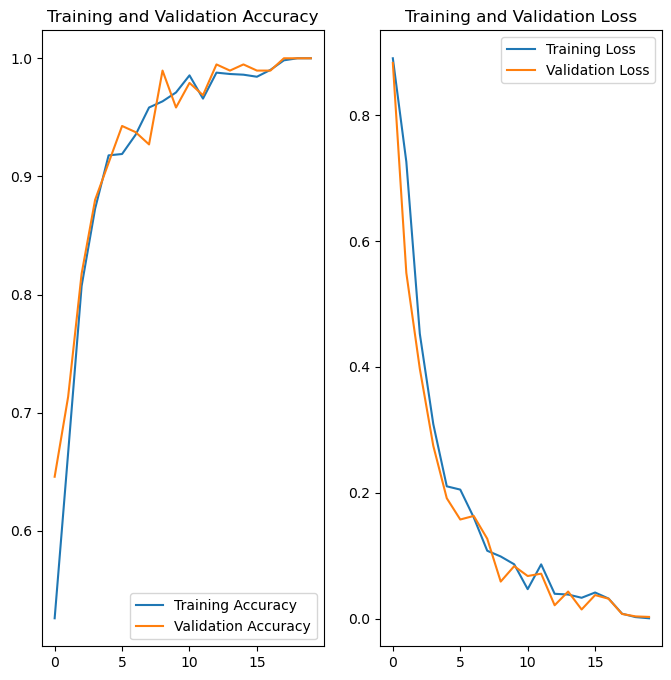

In [48]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 1s 759ms/step
predicted label: Potato___Late_blight


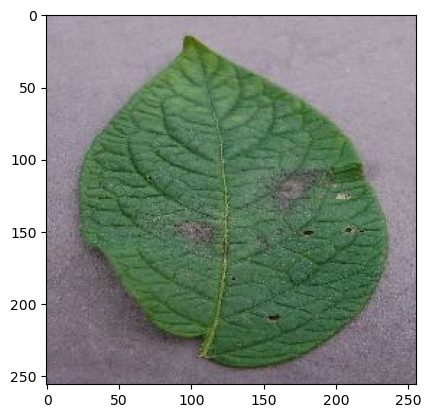

In [49]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [50]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 26ms/step


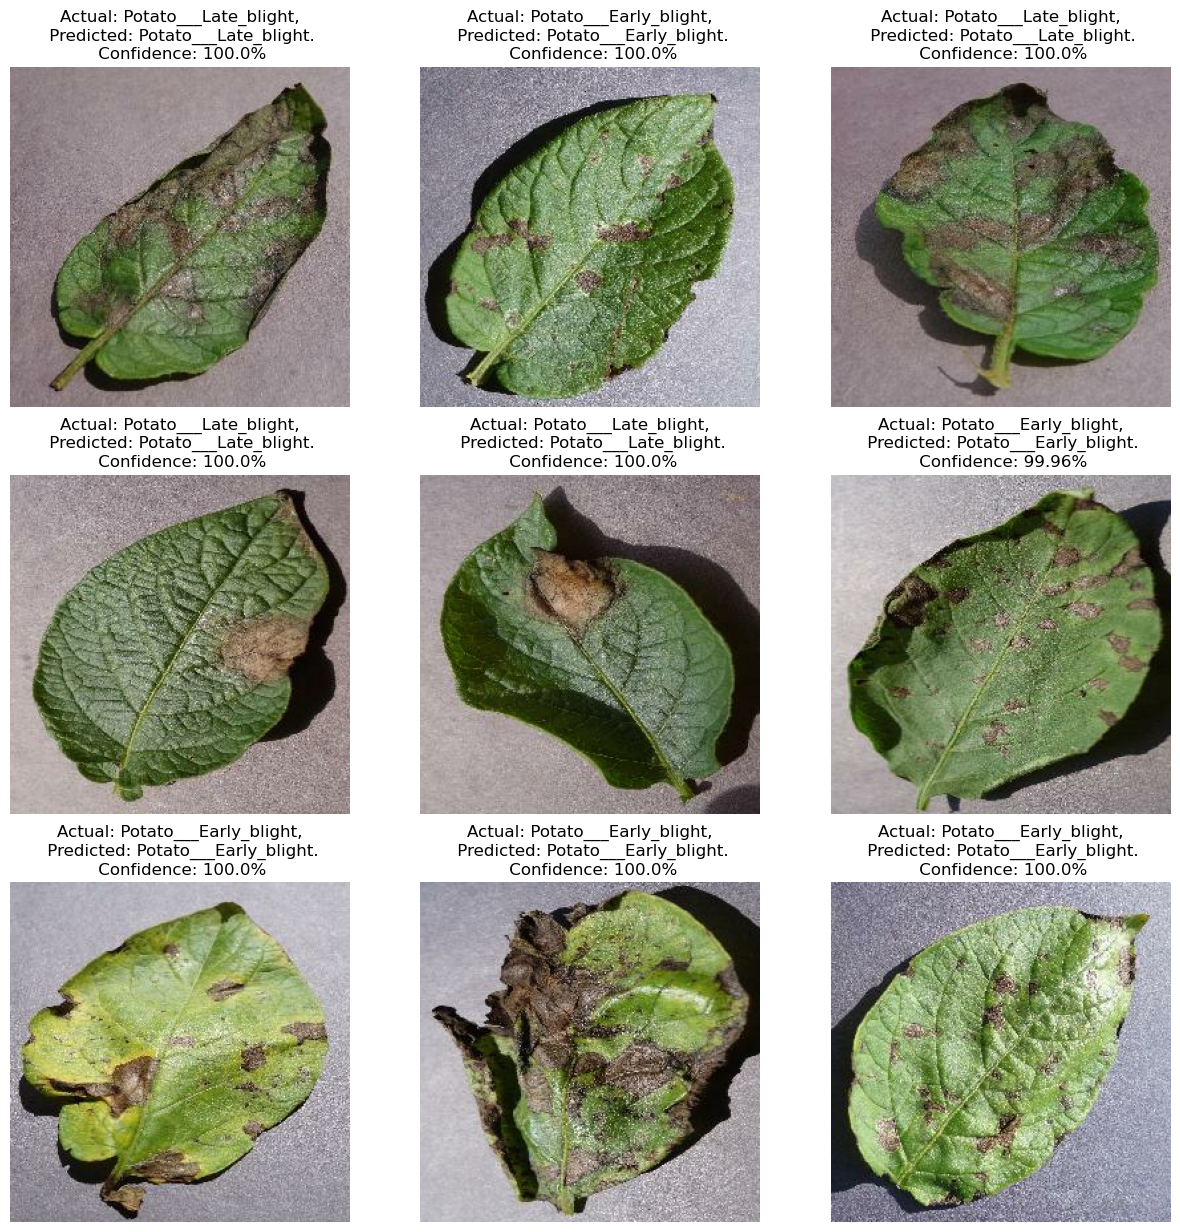

In [51]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")